In [131]:
import torch
import torch.nn as nn
import torchvision
from fractions import Fraction
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from PIL import Image
import tqdm

In [132]:
frame = Fraction(1,30)

In [133]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # Instantiate two convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding=12)
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=3, kernel_size=3, padding=1)
        
        # Instantiate the ReLU nonlinearity
        self.relu = nn.ReLU(inplace=True)
        
        # Instantiate a max pooling layer
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=25, stride=5)
        
        
    def forward(self, x):
        # Apply conv followed by relu, then in next line pool
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        
        # Apply conv followed by relu, then in next line pool
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = self.relu(self.conv3(x))
        
        return x

In [134]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, padding=1)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.sigmoid(x)
        return x

In [135]:
from piqa import SSIM

class ImageQualityLoss(SSIM):
    def forward(self, x, y):
        return 1. - super().forward(torch.nan_to_num(torch.clamp(x[None]/255, min=0, max=1), nan=0),
                                    torch.nan_to_num(torch.clamp(y[None]/255, min=0, max=1), nan=0))

In [136]:
gen = Generator()
dis = Discriminator()
gen_optimizer = optim.Adam(gen.parameters(), lr=3e-4)
dis_optimizer = optim.Adam(dis.parameters(), lr=3e-4)
gen_criterion = nn.L1Loss()
# gen_criterion = ImageQualityLoss()
dis_criterion = nn.L1Loss()
refPool = nn.AvgPool2d(9,10)
batch_size = 100

In [137]:
def CXY_to_XYC(t: torch.Tensor, n:float = 1.0) -> torch.Tensor:
    return torch.Tensor(np.transpose(t.numpy() / n, (1,2,0)))
def XYC_to_CXY(t: torch.Tensor, n:float = 1.0) -> torch.Tensor:
    return torch.Tensor(np.transpose(t.numpy() / n, (2,0,1)))


In [138]:
frames = 171 * 30
start = 3 * 30 * frame
V, A, M = torchvision.io.read_video("images/SteamedHams.mp4", start_pts=start, end_pts=start+(batch_size * frame), pts_unit='sec')



for i in tqdm.trange(10):   
    for b in range(batch_size - 1):
        din = XYC_to_CXY(V[b])
        ref = XYC_to_CXY(V[b + 1])
        ref = refPool(ref)
        
        # 1. Train D on real+fake
        dis.zero_grad()
        
        # 1A: Train D on real
        d_real_decision = dis(ref)
        d_real_error = dis_criterion(d_real_decision, torch.ones(d_real_decision.shape))
        d_real_error.backward()
        
        # 1B: Train D on fake
        out = gen(din).detach()
        d_fake_decision = dis(out)
        d_fake_error = dis_criterion(d_fake_decision, torch.zeros(d_fake_decision.shape))
        d_fake_error.backward()
        
        dis_optimizer.step()
     
    for b in range(batch_size - 1):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        din = XYC_to_CXY(V[b])
        ref = XYC_to_CXY(V[b + 1])
        ref = refPool(ref)
        
        gen.zero_grad()
        out = gen(din)
        decision = dis(out)
        # gen_error = gen_criterion(out, ref)
        gen_error = gen_criterion(decision, torch.ones(decision.size()))
        
        gen_error.backward()
        gen_optimizer.step()
        

    
# out = np.transpose(out.data.numpy(), (1,2,0))


100%|██████████| 10/10 [03:13<00:00, 19.33s/it]


In [139]:
gen.eval()
for i in tqdm.trange(batch_size - 1):
    out = gen(XYC_to_CXY(V[i])).detach()
    Image.fromarray(np.transpose(out.numpy().astype(np.uint8), (1,2,0)),'RGB').save(f"output/frame_{i:05.0f}.png")

100%|██████████| 99/99 [00:04<00:00, 21.15it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


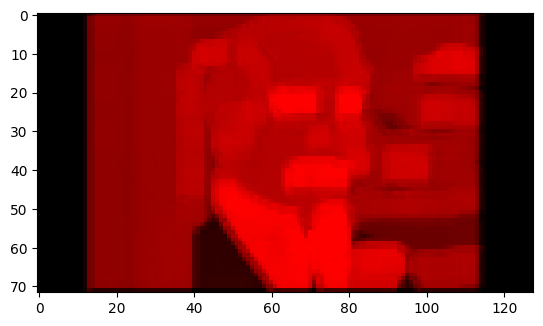

In [146]:
gen.eval()
out = gen(XYC_to_CXY(V[i])).detach()
plt.imshow(np.transpose(out.numpy()/255, (1,2,0)))
# Image.fromarray(),'RGB').save(f"output/frame_{i:05.0f}.png")

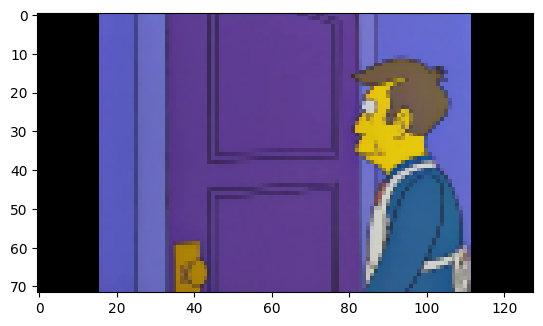

In [147]:
ref = XYC_to_CXY(V[1])
ref = refPool(ref)
Image.fromarray(np.transpose(ref.numpy().astype(np.uint8), (1,2,0)),'RGB').save("ref.png")
plt.imshow(np.transpose(ref.numpy()/255, (1,2,0)))